In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
#%matplotlib ipympl

#%reload_ext tensorboard
#%matplotlib qt

In [3]:
import os
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.io

import networkx as nx
from torch_geometric.utils import from_networkx

import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm.auto import tqdm
import pickle, subprocess
import torch
import sklearn
import csv
import gc
import pydicom

import glob
from platipy.imaging import ImageVisualiser

from lung_nodule_embedding_prediction.pytorch.dataset_class import DatasetGeneratorImage
from lung_nodule_embedding_prediction.pytorch.run_model_torch import RunMalignancyModel
#from hnc_project import data_prep as dp
#from hnc_project import myshow
#from hnc_project import graph_making as gm
#from hnc_project.pytorch import dataset_class as dc
#from hnc_project.pytorch.run_model_torch import RunModel
#%matplotlib notebook
%matplotlib widget
plt.ion()
#import initial_ml as iml

In [4]:
data_dir = '../../data/LIDC-IDRI/'
nii_dir = '../../data/LIDC-IDRI/Nii'
resample_dir = '../../data/LIDC-IDRI/Nii_resample_111'
patch_dir = '../../data/LIDC-IDRI/Nii_111_50'
graph_dir = '../../data/LIDC-IDRI/graph_staging'
edge_dir = '../../data/LIDC-IDRI/edge_staging'
#patch_dir = '../../data/LIDC-IDRI/shulong_files/tensor_32'

id_file = f'{data_dir}/shulong_files/nodules_ids_rates_centers_voxelSizes.mat'

data_path = Path(data_dir)
resample_path = Path(data_dir)
patch_path = Path(patch_dir)
graph_path = Path(graph_dir)
edge_path = Path(edge_dir)

graph_path.mkdir(exist_ok=True, parents=True)
edge_path.mkdir(exist_ok=True, parents=True)


In [5]:
patients = scipy.io.loadmat(id_file)['rate_ids']

## Graph Making

In [99]:
center_pos = np.array(patient_df['position'].tolist())

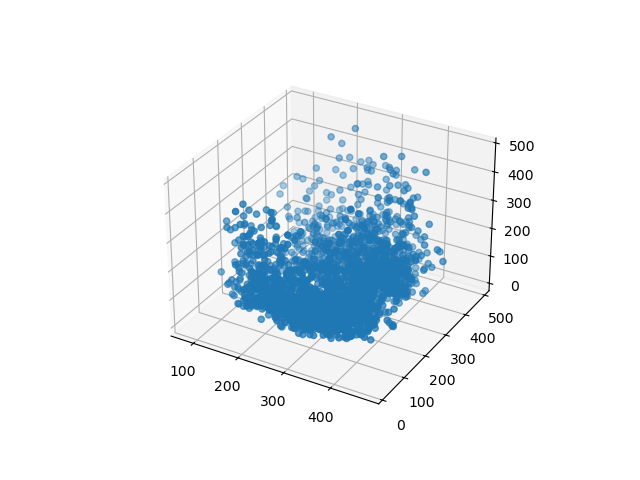

In [158]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(center_pos[:,0], center_pos[:,1], center_pos[:,2])

In [7]:
patient_df = pd.DataFrame(patients, columns=['subject_id', 'label', 'position', 'spacing'])
for idx in patient_df.index:
    patient_df.loc[idx, 'subject_id'] = str(np.squeeze(patient_df.loc[idx, 'subject_id']))
    patient_df.loc[idx, 'label'] = int(np.squeeze(patient_df.loc[idx, 'label']))
    patient_df.loc[idx, 'position'] = np.squeeze(patient_df.loc[idx, 'position'])
    patient_df.loc[idx, 'spacing'] = np.squeeze(patient_df.loc[idx, 'spacing'])
    
patient_df['node'] = patient_df.subject_id.str.split('-', expand=True).iloc[:, 3]
patient_df['subject_id'] = patient_df.subject_id.str.split('-', expand=True)[[0, 1, 2]].agg('-'.join, axis=1)
patient_df.set_index(['subject_id', 'node'], inplace=True)
label_mapping = {1: 0, 2: 0, 3: -1, 4: 1, 5: 1}
patient_df['y'] = patient_df['label'].map(label_mapping)
## L - 0, R - 1
patient_df['laterality'] = np.array(patient_df['position'].tolist())[:,1] >= 256
patient_df['laterality'] = patient_df['laterality'].astype(int)
patient_df[['pos_x', 'pos_y', 'pos_z']] = patient_df['position'].tolist()
patient_df[['spa_x', 'spa_y', 'spa_z']] = patient_df['spacing'].tolist()

In [12]:
patient_df.drop(index=('LIDC-IDRI-0484', '02'), inplace=True)

In [14]:
patient_df.to_pickle(edge_path.joinpath('features_and_labels_032525.pkl'))

In [16]:
patient_graph = {}
edge_dict = {}
for pat in patient_df.index.get_level_values('subject_id').unique():
    patient_graph[pat] = nx.Graph()
    pat_df = patient_df.loc[pat]
    patient_graph[pat].add_nodes_from(patient_df.loc[pat].index)
    edge_dict[pat] = []
    for _, group_df in pat_df.groupby(['laterality']):
        if len(group_df.index) < 2:
            edge_dict[pat].extend([(node, node) for node in group_df.index])
            continue
        for node in group_df.index:
            edge_dict[pat].extend([(node, jnode) for jnode in group_df.index 
                                           if (int(node) != int(jnode))])
    patient_graph[pat].add_edges_from(edge_dict[pat])
    #patient_graph[pat] = patient_graph[pat].to_undirected()
#graph_df = pd.DataFrame(data=patient_graph.values(), index=patient_graph.keys(), columns=["graph"])
#graph_df = pd.DataFrame(data=patient_graph.values(), index=patient_graph.keys())
#patient_df['graph'] = patient_df['graph'].map(patient_graph)
#for idx_node in range(patient_dict['70248556']['nodes']):
#    tpgraph.add_node(idx_node

In [17]:
with open(edge_path.joinpath('proto_graphs_undirected_032525.pkl'), 'wb') as f:
    pickle.dump(patient_graph, f)
    f.close()